# Customer Personality Analysis
We have a dataset from kaggle [https://www.kaggle.com/imakash3011/customer-personality-analysis],  we will apply different clustering algorithms and then evaluate them.  

1. question one  

when you run in google colab it asks your code to "enter in to your drive", it will show a link  [https://accounts.google ...... ]], you follow that link, enter in your gmail account, when you sign in it will show you a  key code... you copy that and put it in your jupyter notebook, where it says "Enter your authorization code:.. then press Enter and it is done   

In [163]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

Mounted at /content/drive/


In [164]:
#UTILITIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.metrics
import sklearn.neighbors
import sklearn.mixture
import warnings
import re
import seaborn as sns


## Load Data and some data munging

2. Data load

The data load is from your google drive, it must be in the folder that you follow by **data_path** variable.

To avoid you problems i recommend you to open a dummy gmail account where there is just the data and the notebook. Other wise you will need to share more credentials and stuff... [https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/] which i believe you want to avoid.... 

In [165]:
#load the data
data_path = '/content/drive/MyDrive/CustomerPersonalityAnalysis/'
data_file = data_path + 'marketing_campaign.csv'
df = pd.read_csv(data_file, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [166]:
#we know that column 'Dt_Customer' is a date, so parse it
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

#search for some columns
to_drop = []
obj_col = []
for col in df.columns:
    if (df[col].dtypes == "object"):
        print(f'Column: {col} is Object type')
        obj_col.append(col)
    if (df[col].nunique()==1):
        print(f'Column: {col} must be dropped because has just one value')
        to_drop.append(col)
    if (df[col].isnull().sum()>0):
        print(f'Column: {col} has missing values')
df = df.dropna()
print('Dropped rows with missing values')
df = df.drop( to_drop, axis=1 )
print('Dropped columns wiht unique values')
df = df.drop_duplicates()
print('Dropped duplicates')


Column: Education is Object type
Column: Marital_Status is Object type
Column: Income has missing values
Column: Z_CostContact must be dropped because has just one value
Column: Z_Revenue must be dropped because has just one value
Dropped rows with missing values
Dropped columns wiht unique values
Dropped duplicates


 Unique elementes in col:  Education
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
 Unique elementes in col:  Marital_Status
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


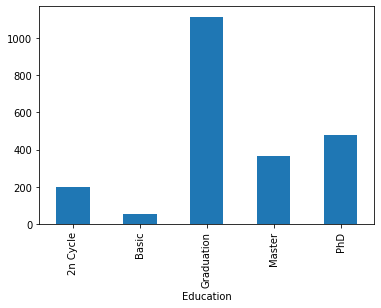

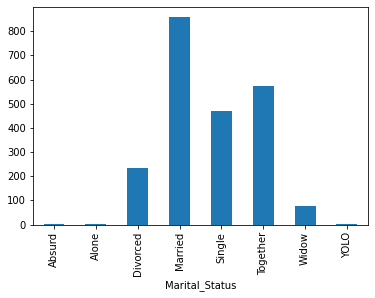

In [167]:
#Check obj_columns 
for col in obj_col:
  if col not in to_drop:
    print(' Unique elementes in col: ', col)
    print(df[col].unique())
    df[['ID',col]].groupby(col).count().plot.bar(legend=None)
    

In [168]:
# mappings to reduce the number of categories 
edu_map = {'Graduation': 0,
           'PhD': 0,
           'Master': 0,
           'Basic': 3,
           '2n Cycle': 3}

marital_map = {'Single': 0,
               'Together': 3,
               'Married': 3,
               'Divorced': 0,
               'Widow': 0,
               'Alone': 0,
               'Absurd': 0,
               'YOLO': 0}

df['C_Marital'] = df['Marital_Status'].replace( marital_map )
df['C_Education'] = df['Education'].replace( edu_map )                       

In [169]:
# Date of data collection will be last date in dataframe + one day
last_Date = df['Dt_Customer'].max() + pd.DateOffset(1)
(last_Date-df['Dt_Customer']).describe()

count                           2216
mean     513 days 00:09:05.848375448
std      232 days 11:15:24.558024988
min                  1 days 00:00:00
25%                341 days 00:00:00
50%                514 days 00:00:00
75%                687 days 00:00:00
max               1064 days 00:00:00
Name: Dt_Customer, dtype: object

In [170]:
# Divide customers in quantiles according to Date of customer's enrollment with the company
def quantile_classification_date( date_d ):
  if (last_Date-date_d) < pd.Timedelta('341 days'):
    return 0
  elif (last_Date-date_d) < pd.Timedelta('514 days'):
    return 1  
  elif (last_Date-date_d) < pd.Timedelta('687 days'):
    return 2
  else:
    return 3  

df['C_seniority'] = df['Dt_Customer'].apply(quantile_classification_date)

In [171]:
#divide in quantiles other columns
def quantile_classification( col ):
  q_arr = df[col].quantile([.25, .5, .75]).values
  def _quantiles( val ):
    if val < q_arr[0]:
      return 0
    elif val < q_arr[1]:
      return 1
    elif val < q_arr[2]:
      return 2
    else:
      return 3
  return  df[col].apply(_quantiles)      

In [172]:
#divide in quantiles other columns

#quantile divition of Year_Birth and Income
df['C_YearBirth'] = pd.qcut(df['Year_Birth'], 4, labels=False )
df['C_Income'] = pd.qcut(df['Income'], 4, labels=False )

In [173]:
#reduce some columns

#number of purchases
df['totalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] +df['NumStorePurchases']
df['C_totalPurchases'] = pd.qcut(df['totalPurchases'], 4, labels=False )

#number of special products
df['totalProducts'] = df['MntFishProducts'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntWines'] + df['MntSweetProducts'] + df['MntGoldProds']
df['C_totalProducts'] = pd.qcut(df['totalProducts'], 4, labels=False )

# children
df['Children'] = df['Kidhome']+df['Teenhome']
df['C_children'] = np.where(df['Children'] > 0, 3, 0)

# complain
df['C_complain'] = np.where(df['Complain'] > 0, 3, 0)

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-nul

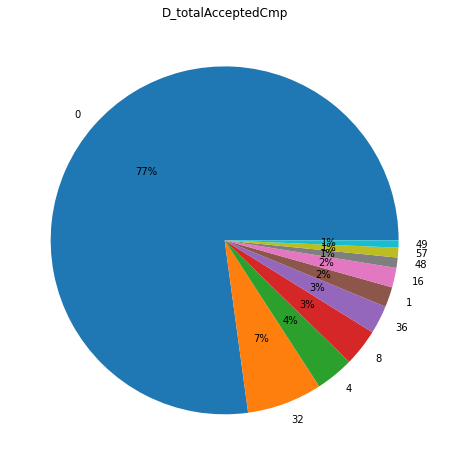

In [175]:
# column of "important" data for company in binary representation
df['D_totalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2']*2 + df['AcceptedCmp3']*2**2 + df['AcceptedCmp4']*2**3 + df['AcceptedCmp5']*2**4 + df['Response']*2**5

def pie_chart(title):
    x = df[title].value_counts()[:10].tolist()
    labels = df[title].value_counts()[:10].index.tolist()

    plt.figure(figsize=(10,8))
    plt.pie(x=x,labels=labels, autopct='%1.0f%%')
    plt.title(title)

pie_chart('D_totalAcceptedCmp')

we see that each combination of Accepted Campaigns has low frequency, so it can't be used as a "label"  for classifying customers

In [176]:
#columns for clustering analysis
clus_col = []
for col in df.columns:
  if re.match(r'C_',col):
    clus_col.append(col)
clus_col    

['C_Marital',
 'C_Education',
 'C_seniority',
 'C_YearBirth',
 'C_Income',
 'C_totalPurchases',
 'C_totalProducts',
 'C_children',
 'C_complain']

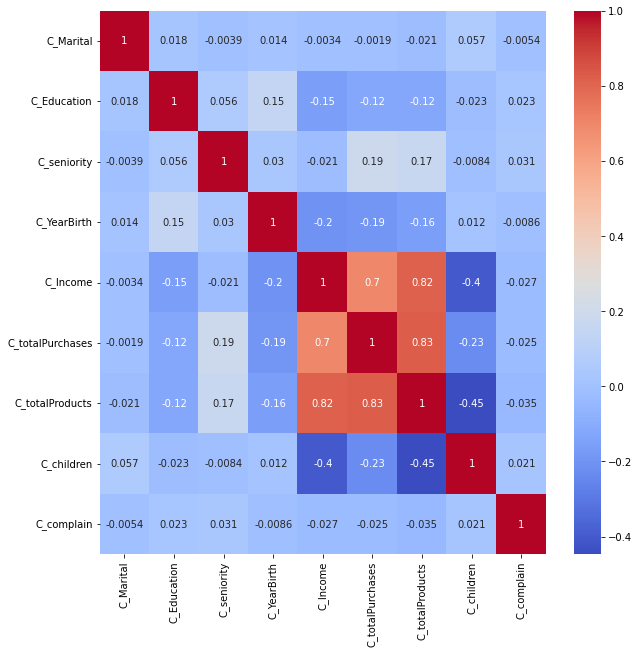

In [177]:
plt.figure( figsize = (10,10) )
sns.heatmap( df[clus_col].corr(), annot = True, cmap='coolwarm' )

We see a high correlation between 'C_totalProducts'  and columns 'C_Income', 'C_totalPurchases', so we could drop that column for clustering analysis.    

In [178]:
clus_col.pop(-3)
clus_col

['C_Marital',
 'C_Education',
 'C_seniority',
 'C_YearBirth',
 'C_Income',
 'C_totalPurchases',
 'C_children',
 'C_complain']

In [179]:
df_red = df[['ID']+clus_col]
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ID                2216 non-null   int64
 1   C_Marital         2216 non-null   int64
 2   C_Education       2216 non-null   int64
 3   C_seniority       2216 non-null   int64
 4   C_YearBirth       2216 non-null   int64
 5   C_Income          2216 non-null   int64
 6   C_totalPurchases  2216 non-null   int64
 7   C_children        2216 non-null   int64
 8   C_complain        2216 non-null   int64
dtypes: int64(9)
memory usage: 173.1 KB


In [180]:
def plot_heatmaps( dff ):
  siz = dff.columns.shape[0] - 1
  fig, ax = plt.subplots( siz,siz, figsize=(30,30) )

  for ii,col_0 in enumerate(dff.columns):
    for jj,col_1 in enumerate(dff.columns):
      if col_0 == 'ID' or col_1 == 'ID':
        continue
      if col_0 == col_1:
        _plot_uniHist( ax[ii-1,jj-1], dff, col_0 )
      else:
        _plot_biHist( ax[ii-1,jj-1], dff, col_0, col_1)
  return       

def _plot_uniHist( ax, dff, col ):
  hh = dff[['ID',col]].groupby(col).count()
  ax.bar(hh['ID'].index, hh['ID'].values)
  ax.set_xlabel( col )
  ax.set_ylabel( 'counts' )
  return

def _plot_biHist( ax, dff, col_0, col_1 ):

  hh = dff[['ID',col_0, col_1]].groupby([col_0,col_1]).count()
  arr = hh.unstack().values
  row_labels = hh.unstack().index.values
  col_labels = hh.unstack(0).index.values

  _heatmap(arr, row_labels, col_labels, col_0, col_1, ax=ax, cmap="YlGn")
  return

#this is from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def _heatmap(data, row_labels, col_labels, row_name, col_name, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    
    ax.set_xlabel(col_name)
    ax.set_ylabel(row_name)

    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticks(np.arange(data.shape[1]))

    # Show all ticks and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return #im, cbar


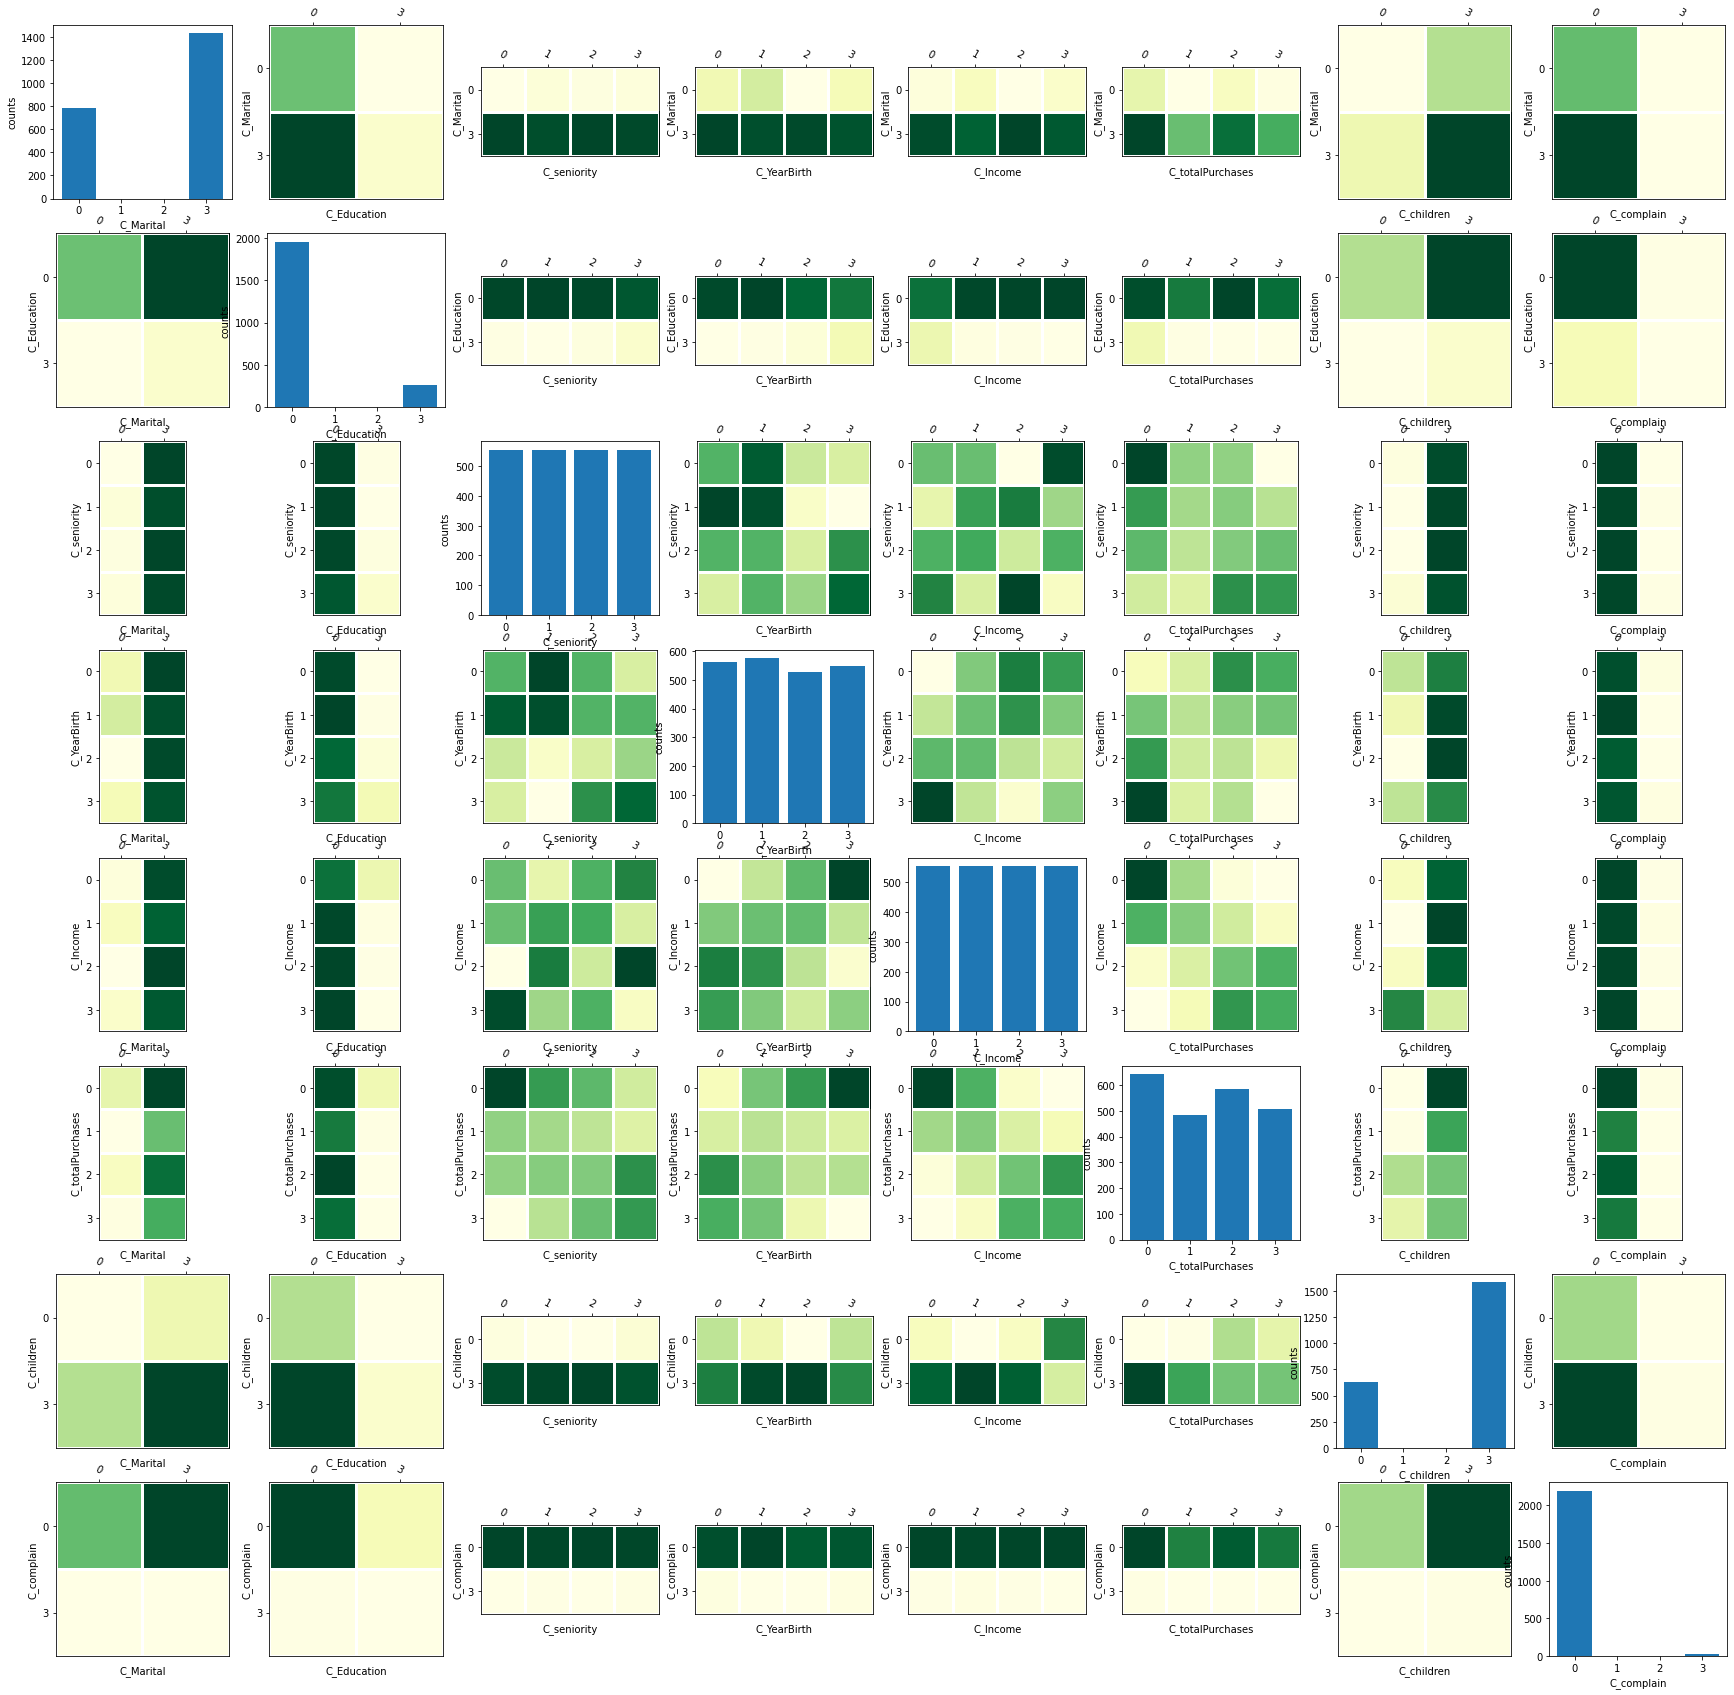

In [181]:
#frequency plots
plot_heatmaps(df_red)

## Clustering Analysis
Taken from ref [https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html]  and [https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient], we will test various clustering methods and see which one gives a better metric.

In [182]:
connectivity = sklearn.neighbors.kneighbors_graph( df_red, n_neighbors=4, include_self=False )
connectivity = 0.5*( connectivity + connectivity.T )

kmeans_4 = sklearn.cluster.MiniBatchKMeans( n_clusters=4 )
ward = sklearn.cluster.AgglomerativeClustering( n_clusters=4, linkage='ward', connectivity=connectivity )
spectral = sklearn.cluster.SpectralClustering( n_clusters=4, eigen_solver='arpack', affinity='nearest_neighbors' )
average_linkage = sklearn.cluster.AgglomerativeClustering( linkage='average', affinity='cityblock', n_clusters=4, connectivity=connectivity )
birch = sklearn.cluster.Birch( n_clusters=4 )
gmm = sklearn.mixture.GaussianMixture( n_components=4, covariance_type='full' )

clustering_algorithms = (
        ("MiniBatch\nKMeans", kmeans_4), 
         ("Spectral\nClustering", spectral), 
        ("Ward", ward), 
        ("Agglomerative\nClustering", average_linkage), 
        ("BIRCH", birch), 
        ("Gaussian\nMixture", gmm), 
    )

sil = []
cal = []
dav = []

for name, algorithm in clustering_algorithms:
  print('Clustering by algorithm ',name)
  with warnings.catch_warnings():
    warnings.filterwarnings(
      "ignore",
      message="the number of connected components of the "
      + "connectivity matrix is [0-9]{1,2}"
      + " > 1. Completing it to avoid stopping the tree early.",
      category=UserWarning,
    )
    warnings.filterwarnings(
      "ignore",
      message="Graph is not fully connected, spectral embedding"
      + " may not work as expected.",
      category=UserWarning,
    )
    algorithm.fit(df_red)

  if hasattr(algorithm, "labels_"):
    y_pred = algorithm.labels_.astype(int)
  else:
    y_pred = algorithm.predict(df_red)

  print("        Silhouette Coefficient (higger better)")
  sil.append(sklearn.metrics.silhouette_score(df_red,y_pred,metric='euclidean'))
  print("       ",sil[-1])
  print("        Calinski-Harabasz Index (higger better)")
  cal.append(sklearn.metrics.calinski_harabasz_score(df_red,y_pred))
  print("       ",cal[-1])
  print("Davies-Bouldin Index (lower better)")
  dav.append(sklearn.metrics.davies_bouldin_score(df_red,y_pred))
  print("       ",dav[-1])
  print("\n\n########################## \n##########################\n##########################\n\n")



Clustering by algorithm  MiniBatch
KMeans
        Silhouette Coefficient (higger better)
        0.5735061355604995
        Calinski-Harabasz Index (higger better)
        11093.841631891908
Davies-Bouldin Index (lower better)
        0.502429802259519


########################## 
##########################
##########################


Clustering by algorithm  Spectral
Clustering
        Silhouette Coefficient (higger better)
        0.5501470023516434
        Calinski-Harabasz Index (higger better)
        9741.088808737639
Davies-Bouldin Index (lower better)
        0.5000701518284819


########################## 
##########################
##########################


Clustering by algorithm  Ward
        Silhouette Coefficient (higger better)
        0.5549687944167094
        Calinski-Harabasz Index (higger better)
        10039.48435513473
Davies-Bouldin Index (lower better)
        0.4995269739914808


########################## 
##########################
#####################

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


        Silhouette Coefficient (higger better)
        0.5549687944167094
        Calinski-Harabasz Index (higger better)
        10039.48435513473
Davies-Bouldin Index (lower better)
        0.4995269739914808


########################## 
##########################
##########################


Clustering by algorithm  Gaussian
Mixture
        Silhouette Coefficient (higger better)
        -0.36698195513502063
        Calinski-Harabasz Index (higger better)
        64.48797141968384
Davies-Bouldin Index (lower better)
        3.347435801166835


########################## 
##########################
##########################




In [183]:
print('Algorithm with better Silhouette Coefficient\n')
print( '   ',clustering_algorithms[np.array(sil).argmax()], ' with sil= ',np.array(sil).max())
print('\nAlgorithm with better Calinski-Harabasz Index\n')
print( '   ',clustering_algorithms[np.array(cal).argmax()], ' with cal= ',np.array(cal).max())
print('\nAlgorithm with better Davies-Bouldin Index\n')
print( '   ',clustering_algorithms[np.array(dav).argmin()], ' with dav= ',np.array(dav).min())

Algorithm with better Silhouette Coefficient

    ('MiniBatch\nKMeans', MiniBatchKMeans(n_clusters=4))  with sil=  0.5735061355604995

Algorithm with better Calinski-Harabasz Index

    ('MiniBatch\nKMeans', MiniBatchKMeans(n_clusters=4))  with cal=  11093.841631891908

Algorithm with better Davies-Bouldin Index

    ('Ward', AgglomerativeClustering(connectivity=<2216x2216 sparse matrix of type '<class 'numpy.float64'>'
	with 10446 stored elements in Compressed Sparse Row format>,
                        n_clusters=4))  with dav=  0.4995269739914808


From last results we see that the method, of MinitBatchMeans gives the best results compared to other methods, so we will use it cluster our data.

In [184]:
df_red['cluster'] = kmeans_4.fit(df_red).labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [185]:
df_red['cluster'].value_counts()

2    585
0    578
1    541
3    512
Name: cluster, dtype: int64

In [186]:
cluster_group = df_red.groupby('cluster')

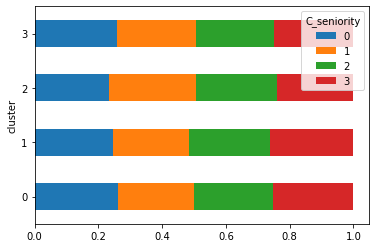

In [187]:
# C_seniority quantiles per cluster
#_plot_biHist(ax, df_red, 'C_seniority','cluster')
normed_cluster_group = cluster_group['C_seniority'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

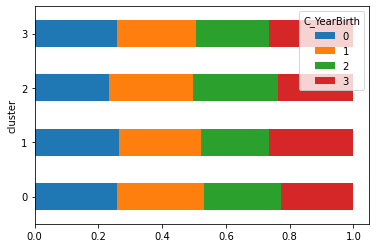

In [188]:
# C_YearBirth quantiles per cluster
normed_cluster_group = cluster_group['C_YearBirth'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

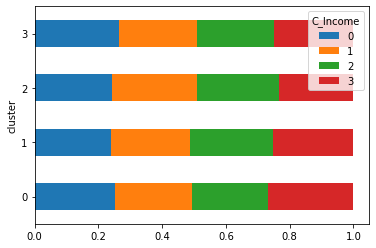

In [189]:
# C_Income quantiles per cluster
normed_cluster_group = cluster_group['C_Income'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

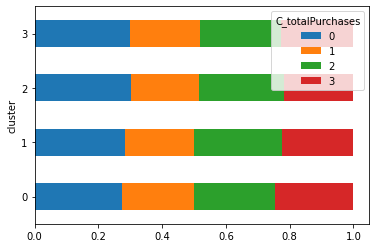

In [190]:
# C_totalPurchases quantiles per cluster
normed_cluster_group = cluster_group['C_totalPurchases'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

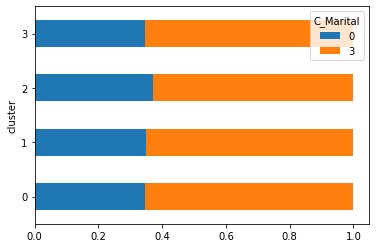

In [191]:
# C_Marital count values per cluster
normed_cluster_group = cluster_group['C_Marital'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

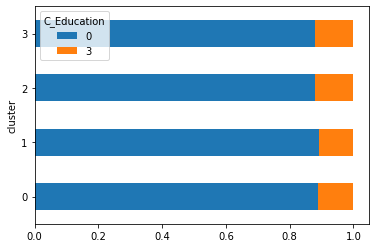

In [192]:
# C_Education count values per cluster
normed_cluster_group = cluster_group['C_Education'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

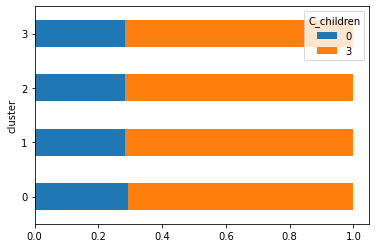

In [193]:
# C_children count values per cluster
normed_cluster_group = cluster_group['C_children'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

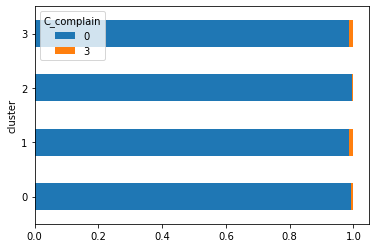

In [194]:
# C_complain count values per cluster
normed_cluster_group = cluster_group['C_complain'].value_counts().unstack()
normed_cluster_group = normed_cluster_group.div(normed_cluster_group.sum(1),axis=0)
normed_cluster_group.plot.barh(stacked=True)

From the last 8 bar plots we can see that each cluster has roughly the same distribution of data. This means that even though our clustering stage was successful, the relations between the data in each cluster are not so obvious, this is an expected result since unsupervised machine learning methods, clustering among them, many times find data relations that are not easy to grasp.   

## Labeling our data
In this section we try to categorize our customers by purchased products, we will apply an unsupervised algorithm to "labelize" costumers. Then use a supervised algorithm to see if we can learn the purchase preferences of each kind of customer.

In [195]:
#start from zero the data
data_path = '/content/drive/MyDrive/CustomerPersonalityAnalysis/'
data_file = data_path + 'marketing_campaign.csv'
df = pd.read_csv(data_file, sep='\t')

#Non statistical preprocessing can be reproduced

#we know that column 'Dt_Customer' is a date, so parse it
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

#search for some columns
to_drop = []
obj_col = []
for col in df.columns:
    if (df[col].dtypes == "object"):
        print(f'Column: {col} is Object type')
        obj_col.append(col)
    if (df[col].nunique()==1):
        print(f'Column: {col} must be dropped because has just one value')
        to_drop.append(col)
    if (df[col].isnull().sum()>0):
        print(f'Column: {col} has missing values')
df = df.dropna()
print('Dropped rows with missing values')
df = df.drop( to_drop, axis=1 )
print('Dropped columns wiht unique values')
df = df.drop_duplicates()
print('Dropped duplicates')

# mappings to reduce the number of categories 
edu_map = {'Graduation': 0,
           'PhD': 0,
           'Master': 0,
           'Basic': 3,
           '2n Cycle': 3}

marital_map = {'Single': 0,
               'Together': 3,
               'Married': 3,
               'Divorced': 0,
               'Widow': 0,
               'Alone': 0,
               'Absurd': 0,
               'YOLO': 0}

df['C_Marital'] = df['Marital_Status'].replace( marital_map )
df['C_Education'] = df['Education'].replace( edu_map )   

# children
df['Children'] = df['Kidhome']+df['Teenhome']
df['C_children'] = np.where(df['Children'] > 0, 3, 0)

# complain
df['C_complain'] = np.where(df['Complain'] > 0, 3, 0)

Column: Education is Object type
Column: Marital_Status is Object type
Column: Income has missing values
Column: Z_CostContact must be dropped because has just one value
Column: Z_Revenue must be dropped because has just one value
Dropped rows with missing values
Dropped columns wiht unique values
Dropped duplicates


In [196]:
#divide train and test groups
import sklearn.model_selection
X_train, X_test = sklearn.model_selection.train_test_split(df, test_size=0.1, random_state=42)
print('test size ',X_test.count()[0])
print('train_size ',X_train.count()[0])

test size  222
train_size  1994


In [197]:
# first clusterize train data by purhcases
PurchProd = [ 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds' ]
kmeans_4 = sklearn.cluster.MiniBatchKMeans( n_clusters=4 )
X_train['labels'] = kmeans_4.fit( X_train[PurchProd] ).labels_
trainlabels_group = X_train.groupby('labels')
trainlabels_group[PurchProd].mean()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
labels,,,,,,
0,1033.202073,49.507772,410.694301,69.569948,50.891192,71.134715
1,80.518828,11.573222,45.444351,15.246862,10.945607,25.968201
2,438.046025,71.121339,578.016736,103.309623,69.958159,77.953975
3,554.910082,33.850136,166.653951,50.613079,38.435967,67.234332


We see that group '1' does not buy to much products.
group '0' buys lots of wine products and secondly meat.
group '2' buys more meat than wine and some amount of fish too.
group '3' buys wines and meat products, but relatively low of other products, specially fruit. 

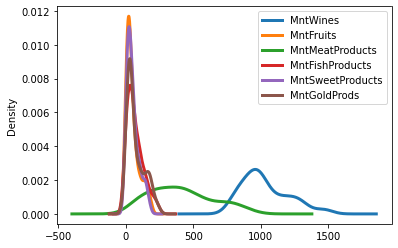

In [198]:
#density plots for cluster 0
X_train[X_train['labels']==0][PurchProd].plot.kde(lw = 3)

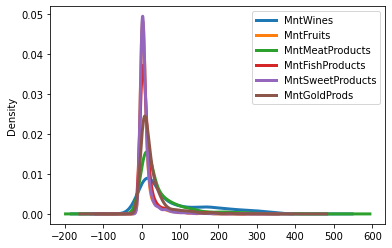

In [199]:
#density plots for cluster 1
X_train[X_train['labels']==1][PurchProd].plot.kde(lw = 3)

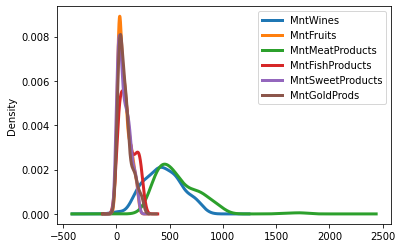

In [200]:
#density plots for cluster 2
X_train[X_train['labels']==2][PurchProd].plot.kde(lw = 3)

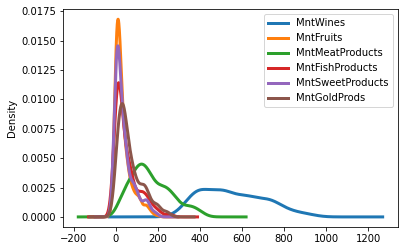

In [201]:
#density plots for cluster 3
X_train[X_train['labels']==3][PurchProd].plot.kde(lw = 3)

We see that each cluster has different products distribution. 

In [202]:
#scaling income without data leak [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn.preprocessing.scale]
import sklearn.preprocessing
IncomeScaler = sklearn.preprocessing.StandardScaler()
IncomeScaler.fit(X_train['Income'].values.reshape(-1,1))
X_train['C_Income'] = IncomeScaler.transform(X_train['Income'].values.reshape(-1,1))
X_test['C_Income'] = IncomeScaler.transform(X_test['Income'].values.reshape(-1,1))

In [203]:
#get the "true labels" for test data
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train[PurchProd],X_train['labels'] )
X_test['labels'] = neigh.predict(X_test[PurchProd] )


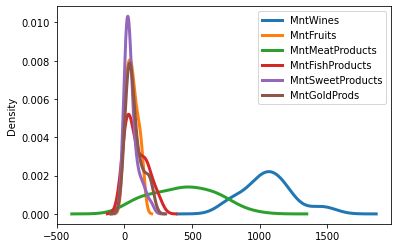

In [204]:
#density plots for cluster 0 in test data
X_test[X_test['labels']==0][PurchProd].plot.kde(lw = 3)

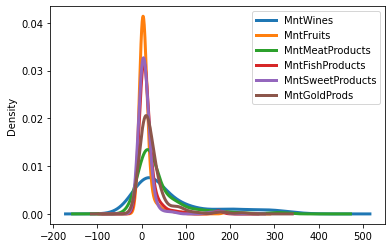

In [205]:
#density plots for cluster 1 in test data
X_test[X_test['labels']==1][PurchProd].plot.kde(lw = 3)

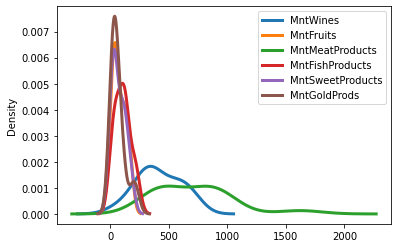

In [206]:
#density plots for cluster 2 in test data
X_test[X_test['labels']==2][PurchProd].plot.kde(lw = 3)

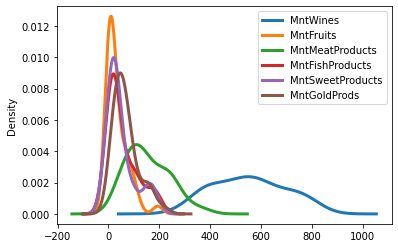

In [207]:
#density plots for cluster 3 in test data
X_test[X_test['labels']==3][PurchProd].plot.kde(lw = 3)

we see that our test data distribution per cluster is similar to train data distribution. So our search of 'true labels' was successful.

Now we will try to train a model to predict in which group/cluster a costumer should belong if we do not know his products purchase.

In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def TrainTest_Classifier( classifier_name, col_names ):

    f_train = X_train[col_names]
    l_train = X_train['labels']

    f_test = X_test[col_names]
    l_test = X_test['labels']

    if classifier_name == 'DecisionTree':
        classif = DecisionTreeClassifier(max_depth=4)
        def ClassifierFunction( ):
            return classif.fit( f_train, l_train )
        
    elif classifier_name == 'LogisticRegression':
        classif = LogisticRegression(solver='lbfgs', max_iter=1000)
        def ClassifierFunction( ):
            return classif.fit( f_train, l_train )
    
    elif classifier_name == 'RandomForest':
        classif = RandomForestClassifier(max_depth=100)
        def ClassifierFunction( ):
            return classif.fit( f_train, l_train )


    print( 'Training' )
    classificated = ClassifierFunction( )
    print( '...' )
    
    print( 'Testing' )
    accuracy_test = sklearn.metrics.accuracy_score( l_test, classificated.predict(f_test) )
    print( 'Accuracy:', accuracy_test)
    print( 'confusion matrix' )
    print( sklearn.metrics.confusion_matrix( l_test, classificated.predict(f_test)  ) )

    return      

In [209]:
classif_list = ['DecisionTree','LogisticRegression','RandomForest']
train_columns = ['Year_Birth', 'C_Education', 'C_Marital', 'C_children', 'C_Income']

results={}
for c in classif_list:
  print('\n#################### \n#################### \n')
  print('classif',c)
  TrainTest_Classifier( c, train_columns )


#################### 
#################### 

classif DecisionTree
Training
...
Testing
Accuracy: 0.6756756756756757
confusion matrix
[[  2   4  18   7]
 [  1 122   4   5]
 [  1   0  15   1]
 [  0  23   8  11]]

#################### 
#################### 

classif LogisticRegression
Training
...
Testing
Accuracy: 0.6666666666666666
confusion matrix
[[  0   3  18  10]
 [  0 122   4   6]
 [  0   0  15   2]
 [  0  24   7  11]]

#################### 
#################### 

classif RandomForest
Training
...
Testing
Accuracy: 0.7342342342342343
confusion matrix
[[ 11   2  13   5]
 [  2 122   3   5]
 [  5   2  10   0]
 [  3  15   4  20]]


We see that from our classification methods, when trying to match the "true labels" of test data, the one with best results is Random Forest. Even though this is the best tested method, we can see that its accuracy is low, probably due the fact that our train data is small, 1994 data points. From the Confusion matrix see that the more problematic clusters are label '0' and '2', where the percentage of true predictions is small, maybe because its distributions are very similar.     